### 1. Load and clean data, in-sample data (2018-2020) and out-of-sample data (2021). From the in- sample data, compute the classical Markowitz and resampled Markowitz frontiers.

a) Import necessary libraries and dataset, compute the matrix of monthly returns

In [1]:
# import libraries and datasets
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Load file and into dateframe
monthlyClosing_inSample = 'monthly_closings_2018_to_2020.csv'
monthlyClosing_outSample = 'monthly_closings_2021.csv'

df1 = pd.read_csv(monthlyClosing_inSample)
df2 = pd.read_csv(monthlyClosing_outSample)

#Remove date
price = df1.iloc[:,1:]

#Calculate monthly return as percent change of monthly closing values, reset indices 
ret = price.pct_change().iloc[1:,:]
ret.reset_index(inplace = True, drop = True)

In [3]:
type(ret)

pandas.core.frame.DataFrame

b) Compute the covariance matrix and means of the percent change matrix 

In [4]:
## Compute the covariance matrix Q and means for each column
# Compute the covariance matrix of the percent change of prices
Q = ret.cov().to_numpy()

# Compute the mean for each column 
mu = np.array(np.mean(ret, axis = 0))

# Store number of features 
n = ret.shape[1] 

c) Solve for the minimum variance portfolio

In [5]:
## Solve for the minimum variance portfolio
# Create optimization variable w1, 26 total variables 
w1 = cp.Variable(n)

# Form the problem , minimize
constraints1 = [sum(w1) == 1 , w1 >= 0]
prob1 = cp.Problem(cp.Minimize(cp.quad_form(w1, Q)) , [sum(w1) == 1 , w1 >= 0])

#Solve Problem
prob1.solve(verbose=False)

0.0009278939303461067

In [6]:
# matrix of allocations which offers the minimum variance 
w_minVar = w1.value #solution value: minimum variance 
w_minVar

array([ 2.34709995e-19,  5.74335977e-20,  8.04914107e-21,  8.47497035e-20,
        1.98804620e-20,  1.09436145e-20,  2.73062165e-20,  2.72297891e-19,
        5.54485957e-02,  1.08374455e-19,  8.96585659e-20,  6.59194971e-01,
       -6.72525493e-20,  2.57094819e-20,  1.76013193e-03,  8.87191244e-02,
        5.48842212e-02, -5.82446152e-20, -4.53771914e-19,  3.42087441e-20,
       -3.00374562e-20,  8.76638311e-20,  9.01180838e-02, -1.21208010e-21,
        4.98748717e-02])

In [7]:
#Compute the variance of the portfolio
var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar)) #variance
var_minVar

0.0009278939303461067

In [8]:
#Compute the return of the portfolio
ret_minVar = np.dot(mu, w_minVar) #expected return
ret_minVar

0.008653285914910979

d) Solve for the maximum variance portfolio

In [9]:
## Solve for the maximum return portfolio
# Create optimization variable w2, 26 total variables 
w2 = cp.Variable(n)

constraints2 = [sum(w2) == 1, w2 >= 0]
prob2 = cp.Problem(cp.Maximize(mu.T@w2), constraints2)
                   
# Solve the problem 
prob2.solve(verbose=False)

0.10211634693131111

In [10]:
# matrix of allocations which offers th
w_maxRet = w2.value #solution value: maximum expected return
w_maxRet

array([4.00446549e-11, 2.33109317e-11, 2.11897368e-11, 2.02514107e-11,
       2.13526338e-11, 2.10766681e-11, 2.36702200e-11, 2.30281295e-11,
       2.20156300e-11, 1.84127151e-11, 1.42266925e-11, 1.97676588e-11,
       1.08469522e-09, 1.88147929e-11, 2.37055006e-11, 1.85314364e-11,
       2.26815434e-11, 2.41212013e-11, 9.99999998e-01, 1.68558540e-11,
       8.78989931e-12, 2.30303345e-11, 2.19747289e-11, 2.02437383e-11,
       1.72961027e-11])

In [11]:
#Compute the variance of the portfolio
var_maxRet = np.dot(w_maxRet, np.dot(Q, w_maxRet)) #variance
var_maxRet

0.33974851965068

In [12]:
#Compute the return of the portfolio
ret_maxRet = np.dot(mu, w_maxRet) #expected return
ret_maxRet

0.10211634693131111

e) Compute the classical Markowitz efficient frontier

In [13]:
## Compute classical Markowitz efficent frontier
#Create tareget ranges for portfolio returns
targetLen = 50
targetRet = np.linspace(ret_minVar,ret_maxRet,targetLen)

In [14]:
# Define optimization problem and compute one portfolio on efficient frontier
w = cp.Variable(n)
eps = cp.Parameter()

constraints3 = [mu.T@w >= eps,sum(w) == 1,w >= 0]
prob3 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)), constraints3)

In [15]:
# Compute efficient frontier
w_front_clas = []
var_front_clas = []
ret_front_clas = []
for epsilon in targetRet:
    eps.value = epsilon
    prob3.solve()
    w_front_clas.append(w.value)
    var_front_clas.append(np.dot(w.value, np.dot(Q, w.value)))
    ret_front_clas.append(np.dot(mu, w.value))

f) Compute the resampled efficient frontier

In [18]:
##Compute the resampled efficient frontier

sample_size = ret.shape[0] 
repetition = 100

#set variables for storing resuts
w_front = []
var_front = []
ret_front = []
w_avg=[]
w_ = np.array(0)
var_re=[]
ret_re=[]
mu_resample_list=[]
Q_resample_list=[]
var_minVar_list=[]
ret_minVar_list=[]
var_maxRet_list=[]
ret_maxRet_list=[]

    
#Usa a random seed so that results will be consistent 
np.random.seed(10)

#Resample by taking n (sample size) draws from the original input
for i in range(repetition):
    
    
    #resample by drawing from the multivariate normal distribution with mu and Q
    x_resample = pd.DataFrame(np.random.multivariate_normal(mu,Q,sample_size))

    
    #Calculate the new mean vector (mu_resample) and new variance-covariance matrix (Q _resample) 
    #resampled mu and Q
    mu_resample = np.array(np.mean(x_resample, axis = 0))
    mu_resample_list.append(mu_resample)
    Q_resample = x_resample.cov().to_numpy()
    Q_resample_list.append(Q_resample)
    #Compute minimum variance
    w_minVar = w1.value #solution value: minimum variance
    var_minVar = np.dot(w_minVar, np.dot(Q_resample, w_minVar)) #variance
    ret_minVar = np.dot(mu_resample, w_minVar) #expected return
    var_minVar_list.append(var_minVar)
    ret_minVar_list.append(ret_minVar)
    
    #compute maximum expected return
    w_maxRet = w2.value #solution value: maximum expected return
    var_maxRet = np.dot(w_maxRet, np.dot(Q_resample, w_maxRet)) #variance
    ret_maxRet = np.dot(mu_resample, w_maxRet) #expected return
    var_maxRet_list.append(var_maxRet)
    ret_maxRet_list.append(ret_maxRet)

    #target return
    targetRet = np.linspace(ret_minVar,ret_maxRet,50)
    
    # Define optimization problem and compute one portfolio on efficient frontier
    w_re = cp.Variable(n)
    eps_re = cp.Parameter()
    
    constraints4 = [mu_resample.T@w_re >= eps_re,sum(w_re) == 1,w_re >= 0]
    prob4 = cp.Problem(cp.Minimize(cp.quad_form(w_re, Q_resample)), constraints4)
    
    # Compute efficient frontier
    w_front_re = []
    var_front_re = []
    ret_front_re = []
    for epsilon in targetRet:
        eps_re.value = epsilon
        prob4.solve()
        w_front_re.append(w_re.value)
        var_front_re.append(np.dot(w_re.value, np.dot(Q_resample, w_re.value)))
        ret_front_re.append(np.dot(mu_resample, w_re.value))
    #Store results for each resampling
    w_front.append(w_front_re)
    var_front.append(var_front_re)
    ret_front.append(ret_front_re)
    
#compute the average weights at each return level    
w_arr = np.array(w_front)
for i in range(repetition):
    w_ = w_ + w_arr[i]
w_avg=w_/repetition

#compute the resampled efficient frontier based on the average weights and orignial mu & Q
for i in range(len(w_avg)):
    var_re.append(np.dot(w_avg[i], np.dot(Q, w_avg[i])))
    ret_re.append(np.dot(mu, w_avg[i]))



/Users/qin/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1333: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


### 2. Using the frontiers, compute three portfolio weights (minimum vaiance, maximum return, and Sharpe ratio) along both the classical and resampled frontiers. Compare the performance of each of these portfolios on the out-of-sample data. Assume a total investment of $1000 and a risk-free return of 0.2% monthly (0.002). 

a) On the classical efficient frontier, find the minimum variance, maximum return, and Sharpe ratio portfolio weights

In [19]:
riskFreeRate = 0.002

#Determine weights of minimum variance and maximum return along the efficient frontier 

#Min variance
orig_weights_minVar = w_front_clas[0]
print("Minimum Variance",orig_weights_minVar)

#Max return 
orig_weights_maxRet = w_front_clas[targetLen - 1]
print("Maximum Return",orig_weights_maxRet)

Minimum Variance [ 3.27230514e-19 -1.14168501e-20 -8.31476257e-22  1.11997349e-19
  1.90859691e-20  1.70010969e-20 -2.67206636e-20  8.07691367e-20
  5.54485957e-02  8.99769245e-20  9.08772714e-20  6.59194971e-01
  9.71734393e-20  3.48208987e-20  1.76013193e-03  8.87191244e-02
  5.48842212e-02 -8.25235299e-20 -1.26901397e-20  4.97870966e-20
  4.42499270e-20  2.33153316e-20  9.01180838e-02  8.74735709e-21
  4.98748717e-02]
Maximum Return [-1.31075269e-15 -6.16528539e-15 -5.19951772e-15 -4.94667076e-15
 -5.26860930e-15 -5.16434209e-15 -6.33874698e-15 -5.85370259e-15
 -5.49013629e-15 -4.51579498e-15 -3.84817773e-15 -4.82621158e-15
  5.15958422e-09 -4.59747759e-15 -6.38732563e-15 -4.54605481e-15
 -5.74461164e-15 -6.86109638e-15  9.99999995e-01 -4.24601328e-15
 -3.09630928e-15 -5.91825243e-15 -5.46379763e-15 -4.93574474e-15
 -4.31381808e-15]


In [20]:
#Compute sharp ratio 
ret_array_clas = np.array(ret_front_clas)
var_array_clas = np.array(var_front_clas)

sharpe_array_clas = (ret_array_clas - riskFreeRate)/np.sqrt(var_array_clas)

weights_sharpe_clas = w_front_clas[sharpe_array_clas.argmax()]
print("Sharpe ratio portfolio weights")
print(sharpe_array_clas)
print(sharpe_array_clas.argmax())
print(weights_sharpe_clas)

Sharpe ratio portfolio weights
[0.21841729 0.27800793 0.32774795 0.36827174 0.4008275  0.42613411
 0.44630936 0.46246746 0.47543186 0.48587106 0.49430315 0.50103627
 0.5064046  0.51069581 0.51411326 0.51665943 0.51848227 0.5197395
 0.52055446 0.52102369 0.52122284 0.52121134 0.52103597 0.52073366
 0.52033363 0.51985904 0.5193283  0.51875604 0.51815393 0.51753126
 0.51689544 0.51625237 0.51560673 0.51496224 0.51432183 0.51368778
 0.5130289  0.51215006 0.50586457 0.49160956 0.47226911 0.45041653
 0.42794104 0.40604084 0.38566114 0.3420309  0.28395628 0.23536734
 0.19889106 0.17176165]
20
[ 3.03160097e-01 -2.51104684e-22 -2.18834623e-22 -9.98195762e-22
  2.80063553e-22  1.40269759e-22  1.05222599e-22  1.36537702e-21
  8.22330413e-22  1.19218622e-22 -1.36878928e-22  4.07725910e-01
  1.68209250e-01 -4.02460862e-22  1.73977686e-21 -1.13658312e-21
 -6.17327472e-22  6.85033555e-22  2.27436297e-02  1.41718742e-22
  9.81611134e-02 -2.17487770e-22 -1.21027064e-21  1.21213741e-22
 -1.79537982e-22]

b) On the resampled efficient fronter, find the minimum variance, maximum return, and Sharpe ratio portfolio weights

In [21]:
#Min variance
re_weights_minVar = w_avg[0]
print("Minimum Variance",re_weights_minVar)

#Max return 
re_weights_maxRet = w_avg[targetLen - 1]
print("Maximum Return",re_weights_maxRet)

#Compute sharp ratio 
ret_array_re = np.array(ret_re)
var_array_re = np.array(var_re)

sharpe_array_re = (ret_array_re - riskFreeRate)/np.sqrt(var_array_re)

weights_sharpe_re = w_avg[sharpe_array_re.argmax()]
print("Sharpe ratio portfolio weights")
print(sharpe_array_re)
print(sharpe_array_re.argmax())
print(weights_sharpe_re)

Minimum Variance [1.18833694e-04 8.22788708e-05 4.39524064e-22 3.14852039e-03
 4.11171951e-03 6.41407288e-21 2.17810382e-20 6.07880629e-03
 3.93656373e-02 4.10733379e-20 7.36619587e-03 6.27957896e-01
 4.93381725e-05 1.92320144e-02 8.22776385e-03 9.64655736e-02
 5.43689891e-02 1.99571894e-04 8.17066586e-04 8.48419363e-21
 1.90183873e-03 2.95789507e-20 6.80782000e-02 1.39289144e-02
 4.85008411e-02]
Maximum Return [ 8.59273806e-02 -1.29628582e-06 -1.14014583e-06  6.20483126e-03
  2.50690995e-03 -1.19442986e-06 -1.42547713e-06  1.58370811e-03
  7.39130949e-03  6.52436489e-03  6.00827890e-03  1.95024768e-01
  1.14375415e-01  1.00770392e-02  1.13497461e-03  5.17016664e-02
  1.71518392e-02 -1.45684441e-06  3.96728859e-01 -1.00112308e-06
  3.63788814e-02 -1.21424160e-06  2.19583090e-02  7.72471861e-03
  3.16054759e-02]
Sharpe ratio portfolio weights
[0.2278788  0.24556851 0.26978777 0.29274949 0.31445253 0.33473952
 0.35300519 0.36883772 0.38282855 0.39482204 0.40500956 0.4136533
 0.4213151  0

c) For each of the 6 portfolios, calculate the expected return on the 2022 (out-of-sample) data for a $1000 investment

In [34]:
#drop date
price2021 = df2.iloc[:,1:]

#We want return for the whole year so only use first and last month
price2021_ = price2021.drop(price2021.index[1:11])
price2021_.reset_index(inplace = True, drop = True)

#Compute percent change
ret_2021 = price2021_.pct_change().iloc[1:,:]

ret_2021

,AMD,OXY,XLF,BABA,F,BAC,CCL,AMC,DAL,FB,...,UNH,MMM,AAL,MULN,QQQ,AAPL,XLE,FXI,JPM,V
1,0.68029,0.446726,0.366112,-0.53201,0.982391,0.522067,0.077665,1.051282,0.029505,0.302017,...,0.521509,0.043312,0.04601,-0.584591,0.269255,0.353931,0.458557,-0.256478,0.261573,0.128286


In [23]:
#Minimum variance portfolio
#orig_weights_minVar
orig_minVar_ret2021 = np.dot(ret_2021, orig_weights_minVar)
print("Minimum Variance of original weights",orig_minVar_ret2021)
re_minVar_ret2021 = np.dot(ret_2021, re_weights_minVar)
print("Minimum Variance of resampled weights",re_minVar_ret2021)

#Maximum return portfolio
#orig_weights_maxRet
orig_maxRet_ret2021 = np.dot(ret_2021, orig_weights_maxRet)
print("Maximum Return of original weights",orig_maxRet_ret2021)
re_maxRet_ret2021 = np.dot(ret_2021, re_weights_maxRet)
print("Maximum Return of resampled weights",re_maxRet_ret2021)

#Sharpe ratio portfolio
#orig_weights_sharpe
orig_sharpe_ret2021 = np.dot(ret_2021, weights_sharpe_clas)
print("Sharpe ratio of original weights",orig_sharpe_ret2021)
re_sharpe_ret2021 = np.dot(ret_2021, weights_sharpe_re)
print("Sharpe ratio of resampled weights",re_sharpe_ret2021)

Minimum Variance of original weights [0.02822425]
Minimum Variance of resampled weights [0.0651822]
Maximum Return of original weights [-0.58459094]
Maximum Return of resampled weights [-0.08668626]
Sharpe ratio of original weights [0.27958832]
Sharpe ratio of resampled weights [0.22518455]


In [24]:
#Compute returns on $1000

print('Out-of-sample returns on $1000 investment: \n')
print('On the Classical Efficient Frontier, the minimum variance portfolio returns $' , orig_minVar_ret2021*1000)
print('On the Classical Efficient Frontier, the maximum return portfolio returns $' , orig_maxRet_ret2021*1000)
print('On the Classical Efficient Frontier, the optimal Sharpe ratio portfolio returns $' , orig_sharpe_ret2021*1000 , '\n')
print('On the Resampled Efficient Frontier, the minimum variance portfolio returns $' , re_minVar_ret2021*1000)
print('On the Resampled Efficient Frontier, the maximum return portfolio returns $' , re_maxRet_ret2021*1000)
print('On the Resampled Efficient Frontier, the optimal Sharpe ratio portfolio returns $' , re_sharpe_ret2021*1000)

Out-of-sample returns on $1000 investment: 

On the Classical Efficient Frontier, the minimum variance portfolio returns $ [28.22424688]
On the Classical Efficient Frontier, the maximum return portfolio returns $ [-584.59094047]
On the Classical Efficient Frontier, the optimal Sharpe ratio portfolio returns $ [279.5883226] 

On the Resampled Efficient Frontier, the minimum variance portfolio returns $ [65.18219508]
On the Resampled Efficient Frontier, the maximum return portfolio returns $ [-86.68626416]
On the Resampled Efficient Frontier, the optimal Sharpe ratio portfolio returns $ [225.18455496]


### 3. Plot the classical and resampled efficient frontiers

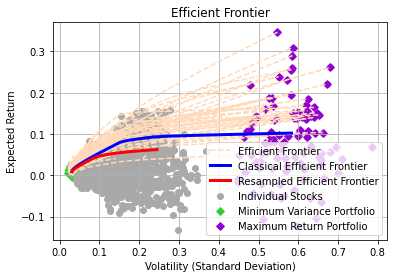

In [25]:
var_frontC_list=var_front
ret_frontC_list=ret_front
var_frontC_resample=var_re
ret_frontC_resample=ret_re

axC = plt.gca()
plt.rcParams['figure.figsize'] = [9, 8]

for i in range(repetition):
    # Plot volatility versus expected return for individual stocks
    axC.scatter(x=np.sqrt(np.diag(Q_resample_list[i])), y=mu_resample_list[i], color='darkgray', label='Individual Stocks' if i == 0 else "")
    
    # Plot volatility versus expected return for mimimum variance portfolio
    axC.scatter(x=np.sqrt(var_minVar_list[i]), y=ret_minVar_list[i], marker='D', s=30,  color='limegreen', label='Minimum Variance Portfolio' if i == 0 else "")

    # Plot volatility versus expected return for maximum return portfolio
    axC.scatter(x=np.sqrt(var_maxRet_list[i]), y=ret_maxRet_list[i],  marker='D', s=30, color='darkviolet', label='Maximum Return Portfolio' if i == 0 else "")

    # Plot efficient frontier
    axC.plot(np.sqrt(var_frontC_list[i]), ret_frontC_list[i], '--', color='peachpuff', label='Efficient Frontier' if i == 0 else "")

#Plot the classical mean-variance efficient frontier
axC.plot(np.sqrt(var_front_clas), ret_front_clas, color='blue', linewidth=3, label='Classical Efficient Frontier')

#Plot the resampled efficient frontier
axC.plot(np.sqrt(var_frontC_resample), ret_frontC_resample, color='red', linewidth=3, label='Resampled Efficient Frontier')

axC.set_xlabel('Volatility (Standard Deviation)')
axC.set_ylabel('Expected Return')
plt.title('Efficient Frontier')
axC.legend(loc="lower right")
axC.grid()
plt.show()


### 4.	Plot the portfolio compositions for classical and resampled frontiers.

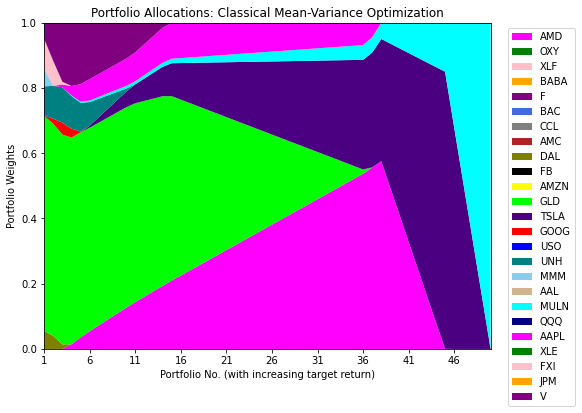

In [30]:
#classical frontiers
x_tick = np.arange(len(targetRet))+1
color_list = ['fuchsia','green','pink','orange','purple','royalblue','grey','firebrick','olive','black','yellow','lime','indigo','red','blue','teal','skyblue','tan','cyan','navy']
plt.figure(figsize=(8, 6))
plt.stackplot(x_tick, np.array(w_front_clas).T, colors=color_list)
plt.legend(df1.columns[1:], bbox_to_anchor=(1.2, 1))
plt.xlim((1,len(targetRet)))
plt.ylim((0,1))
plt.xticks(np.arange(1,len(targetRet)+1,5))
plt.xlabel("Portfolio No. (with increasing target return)")
plt.ylabel("Portfolio Weights")
plt.title("Portfolio Allocations: Classical Mean-Variance Optimization")
plt.show()

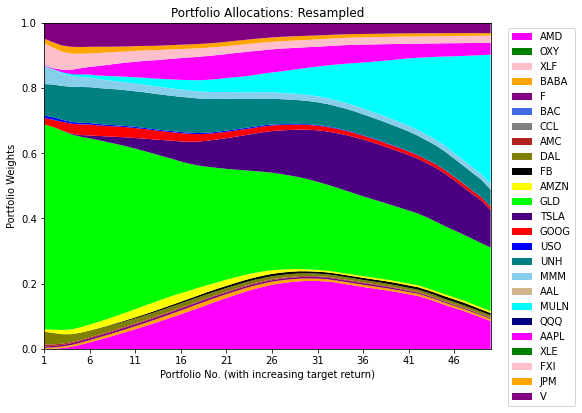

In [27]:
#Resampled frontiers

x_tick = np.arange(len(targetRet))+1
color_list = ['fuchsia','green','pink','orange','purple','royalblue','grey','firebrick','olive','black','yellow','lime','indigo','red','blue','teal','skyblue','tan','cyan','navy']
plt.figure(figsize=(8, 6))
#plt.stackplot(x_tick, np.array(average_weight_list).T, colors=color_list)
plt.stackplot(x_tick, np.array(w_avg).T, colors=color_list)
plt.legend(df1.columns[1:], bbox_to_anchor=(1.2, 1))
plt.xlim((1,len(targetRet)))
plt.ylim((0,1))
plt.xticks(np.arange(1,len(targetRet)+1,5))
plt.xlabel("Portfolio No. (with increasing target return)")
plt.ylabel("Portfolio Weights")
plt.title("Portfolio Allocations: Resampled")
plt.show()
